In [1]:
!pip -q install python-Levenshtein textstat spacy rouge-score bert-score nltk

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 26.8 MB/s eta 0:00:00


In [2]:

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
import Levenshtein
import textstat
import spacy
import random
import pandas as pd
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
import bert_score
import torch

# Download the 'wordnet' resource
nltk.download('wordnet')
nltk.download('omw-1.4')

# Set pandas options to display the entire text
pd.set_option('display.max_colwidth', None)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [3]:
train_data = pd.read_json("https://raw.githubusercontent.com/google-research-datasets/Disfl-QA/main/train.json", orient='index')
val_data = pd.read_json("https://raw.githubusercontent.com/google-research-datasets/Disfl-QA/main/dev.json", orient='index')
test_data = pd.read_json("https://raw.githubusercontent.com/google-research-datasets/Disfl-QA/main/test.json", orient='index')


#clean data
train_data = train_data[(train_data['disfluent'].str.len() >= 25)]
val_data = val_data[(val_data['disfluent'].str.len() >= 25)]
test_data = test_data[(test_data['disfluent'].str.len() >= 25)]

In [15]:
def evaluate_predictions(df, reference_col='Original (Fluent)', prediction_col='Predictions (Fluent)', device='cuda'):
    # Initialize scorers
    rouge_scorer_inst = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    smoothing_function = SmoothingFunction().method4

    # Initialize lists to store individual scores
    rouge1_scores, rouge2_scores, rougeL_scores = [], [], []
    bleu_scores, meteor_scores = [], []
    bert_scores_precision, bert_scores_recall, bert_scores_f1 = [], [], []

    # Move to GPU if available
    if device == 'cuda' and torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    # Iterate through dataframe rows
    for _, row in df.iterrows():
        reference = row[reference_col]
        prediction = row[prediction_col]

        # ROUGE scores
        rouge_scores = rouge_scorer_inst.score(reference, prediction)
        rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
        rouge2_scores.append(rouge_scores['rouge2'].fmeasure)
        rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

        # BLEU score
        bleu = sentence_bleu([reference.split()], prediction.split(), smoothing_function=smoothing_function)
        bleu_scores.append(bleu)

        # METEOR score
        meteor = meteor_score([reference.split()], prediction.split())  # Tokenizing both reference and prediction
        meteor_scores.append(meteor)

        # BERTScore (precision, recall, F1)
        P, R, F1 = bert_score.score([prediction], [reference], lang="en", verbose=False, device=device)
        bert_scores_precision.append(P.mean().item())
        bert_scores_recall.append(R.mean().item())
        bert_scores_f1.append(F1.mean().item())

    # Create a results dictionary
    results = {
        'ROUGE-1': sum(rouge1_scores) / len(rouge1_scores),
        'ROUGE-2': sum(rouge2_scores) / len(rouge2_scores),
        'ROUGE-L': sum(rougeL_scores) / len(rougeL_scores),
        'BLEU': sum(bleu_scores) / len(bleu_scores),
        'METEOR': sum(meteor_scores) / len(meteor_scores),
        'BERTScore Precision': sum(bert_scores_precision) / len(bert_scores_precision),
        'BERTScore Recall': sum(bert_scores_recall) / len(bert_scores_recall),
        'BERTScore F1': sum(bert_scores_f1) / len(bert_scores_f1),
    }

    # Convert results to dataframe for better display
    results_df = pd.DataFrame([results])

    return results_df


In [5]:
# Download necessary resources
nltk.download('punkt')
nltk.download('stopwords')

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Define stop words
stop_words = set(stopwords.words('english'))

# Preprocess text: remove punctuation, convert to lowercase, and remove stopwords
def preprocess(text):
    text = re.sub(r'[^\w\s]', '', text.lower())  # Remove punctuation and lowercase
    return [word for word in text.split() if word not in stop_words]  # Remove stopwords

# Function to calculate word and character counts
def calculate_word_char_counts(df, col1, col2):
    df[f'{col1}_word_count'] = df[col1].str.split().str.len()
    df[f'{col2}_word_count'] = df[col2].str.split().str.len()
    df[f'{col1}_char_count'] = df[col1].str.len()
    df[f'{col2}_char_count'] = df[col2].str.len()

# Function to plot word and character count distributions
def plot_word_char_distributions(df, col1, col2):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].hist([df[f'{col1}_word_count'], df[f'{col2}_word_count']], bins=10, alpha=0.7, label=[col1.capitalize(), col2.capitalize()])
    axs[0].set_title('Word Count Distribution')
    axs[0].set_xlabel('Word Count')
    axs[0].set_ylabel('Frequency')
    axs[0].legend()

    axs[1].hist([df[f'{col1}_char_count'], df[f'{col2}_char_count']], bins=10, alpha=0.7, label=[col1.capitalize(), col2.capitalize()])
    axs[1].set_title('Character Count Distribution')
    axs[1].set_xlabel('Character Count')
    axs[1].set_ylabel('Frequency')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Function to generate n-grams and their frequencies
def generate_ngrams(df, column, n=1):
    all_ngrams = Counter([' '.join(ngram) for sentence in df[column].apply(preprocess) for ngram in ngrams(sentence, n)])
    return all_ngrams

# Function to plot n-grams as bar plots
def plot_ngram_frequencies(ngram_counts, title, top_n=25):
    # Convert the n-gram counts to a DataFrame and sort by count
    ngram_df = pd.DataFrame(ngram_counts.items(), columns=['ngram', 'count']).sort_values(by='count', ascending=False).head(top_n)

    # Create the figure and axis manually with the desired size
    plt.figure(figsize=(16, 8))

    # Plot using matplotlib directly
    plt.bar(ngram_df['ngram'], ngram_df['count'])

    # Set the title and labels
    plt.title(f'Top {top_n} {title}')
    plt.xlabel(f'{title}')
    plt.ylabel('Frequency')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Adjust the layout to prevent label cutoff
    plt.tight_layout()

    # Show the plot
    plt.show()

# Function to calculate Levenshtein distance
def calculate_levenshtein(df, col1, col2):
    df['levenshtein_distance'] = df.apply(lambda row: Levenshtein.distance(row[col1], row[col2]), axis=1)
    return df['levenshtein_distance'].mean()

# Function to calculate readability metrics
def calculate_readability_metrics(text):
    if not text or not text.strip():
        return {'flesch_kincaid_grade': np.nan, 'gunning_fog': np.nan, 'complex_words_percentage': np.nan}
    return {
        'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
        'gunning_fog': textstat.gunning_fog(text),
        'complex_words_percentage': (textstat.difficult_words(text) / len(text.split())) * 100
    }

# Function to plot readability metrics
def plot_readability_metrics(df, col1, col2):
    df[f'{col1}_metrics'] = df[col1].apply(calculate_readability_metrics)
    df[f'{col2}_metrics'] = df[col2].apply(calculate_readability_metrics)

    col1_metrics_df = pd.json_normalize(df[f'{col1}_metrics'])
    col2_metrics_df = pd.json_normalize(df[f'{col2}_metrics'])

    average_col1_metrics = col1_metrics_df.mean()
    average_col2_metrics = col2_metrics_df.mean()

    metrics_df = pd.DataFrame({
        'Metric': ['Flesch-Kincaid Grade Level', 'Gunning Fog Index', 'Complex Words Percentage'],
        f'{col1.capitalize()}': [
            average_col1_metrics['flesch_kincaid_grade'],
            average_col1_metrics['gunning_fog'],
            average_col1_metrics['complex_words_percentage']
        ],
        f'{col2.capitalize()}': [
            average_col2_metrics['flesch_kincaid_grade'],
            average_col2_metrics['gunning_fog'],
            average_col2_metrics['complex_words_percentage']
        ]
    })

    x = np.arange(len(metrics_df))  # The x locations for the groups
    width = 0.35  # The width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, metrics_df[col1.capitalize()], width, label=col1.capitalize(), color='blue')
    bars2 = ax.bar(x + width/2, metrics_df[col2.capitalize()], width, label=col2.capitalize(), color='red')

    ax.set_xlabel('Readability Metrics')
    ax.set_ylabel('Scores')
    ax.set_title(f'Average Readability Metrics for {col1.capitalize()} vs {col2.capitalize()} Text')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_df['Metric'])
    ax.legend()

    # Adding labels on top of bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        ha='center', va='bottom', textcoords="offset points", xytext=(0, 3))

    plt.tight_layout()
    plt.show()

# Function to get POS tag distribution using spaCy
def get_pos_distribution(texts):
    pos_counts = Counter()
    for text in texts:
        doc = nlp(text)
        pos_counts.update([token.pos_ for token in doc])
    return pos_counts

# Function to plot POS tag distributions for specified columns
def plot_pos_distribution(df, col1, col2):
    col1_pos_distribution = get_pos_distribution(df[col1])
    col2_pos_distribution = get_pos_distribution(df[col2])

    pos_df = pd.DataFrame([col1_pos_distribution, col2_pos_distribution],
                          index=[f'{col1.capitalize()}', f'{col2.capitalize()}']).T.fillna(0)

    pos_df.plot(kind='bar', figsize=(10, 6))
    plt.title(f'POS Tag Distribution Comparison: {col1.capitalize()} vs. {col2.capitalize()} Texts')
    plt.xlabel('Part of Speech Tag')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.legend(title='Text Type')
    plt.show()

# Main analysis function
def analyze_disfluency(df, col1='original', col2='disfluent'):
    # Preprocess text
    df['processed_disfluent'] = df[col2].apply(preprocess)

    # Word and character count analysis
    calculate_word_char_counts(df, col1, col2)
    plot_word_char_distributions(df, col1, col2)

    # N-gram analysis
    unigrams = generate_ngrams(df, col2, n=1)
    bigrams = generate_ngrams(df, col2, n=2)
    trigrams = generate_ngrams(df, col2, n=3)

    # Plot top N unigrams, bigrams, and trigrams
    plot_ngram_frequencies(unigrams, 'Unigrams', top_n=25)
    plot_ngram_frequencies(bigrams, 'Bigrams', top_n=25)
    plot_ngram_frequencies(trigrams, 'Trigrams', top_n=25)

    # Levenshtein distance analysis
    avg_levenshtein = calculate_levenshtein(df, col1, col2)
    print(f"\nAverage Levenshtein Distance: {avg_levenshtein}")

    # Readability metrics analysis
    plot_readability_metrics(df, col1, col2)

    # POS tag distribution analysis
    plot_pos_distribution(df, col1, col2)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


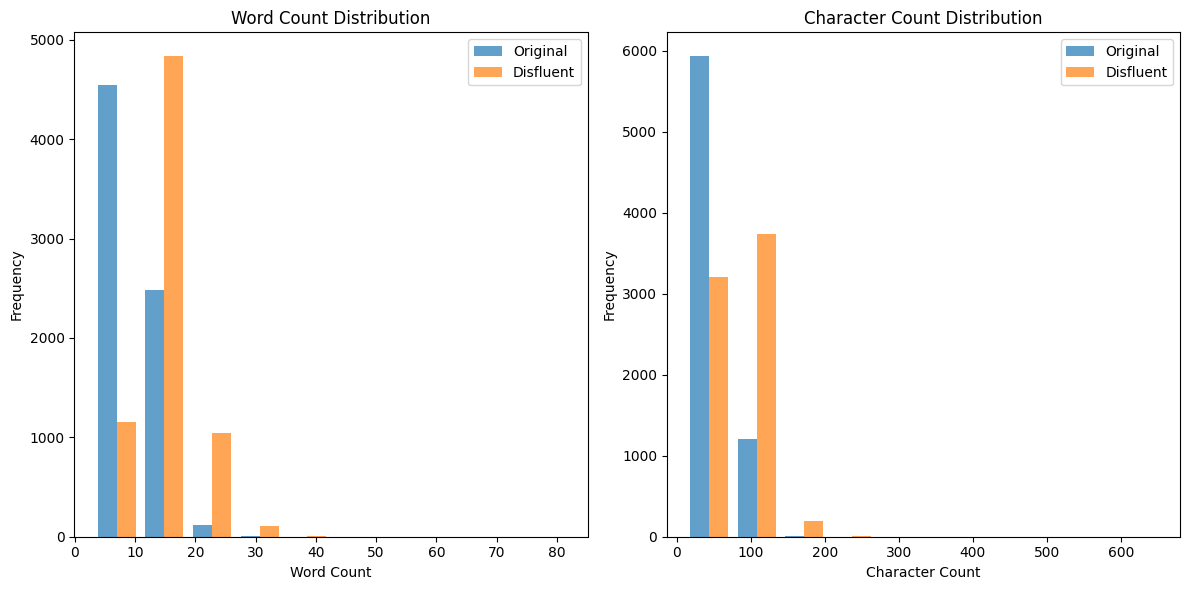

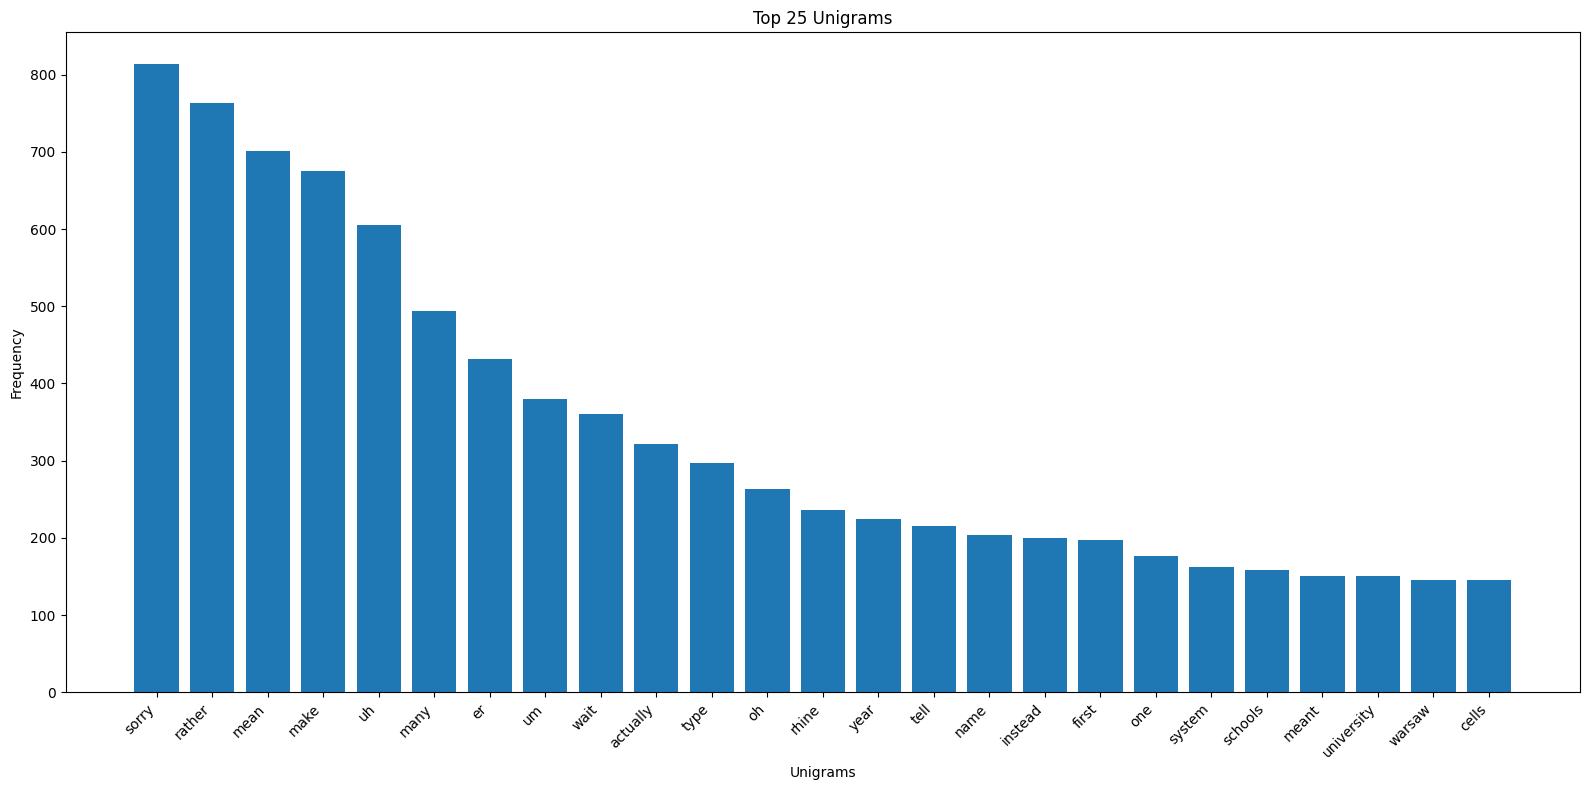

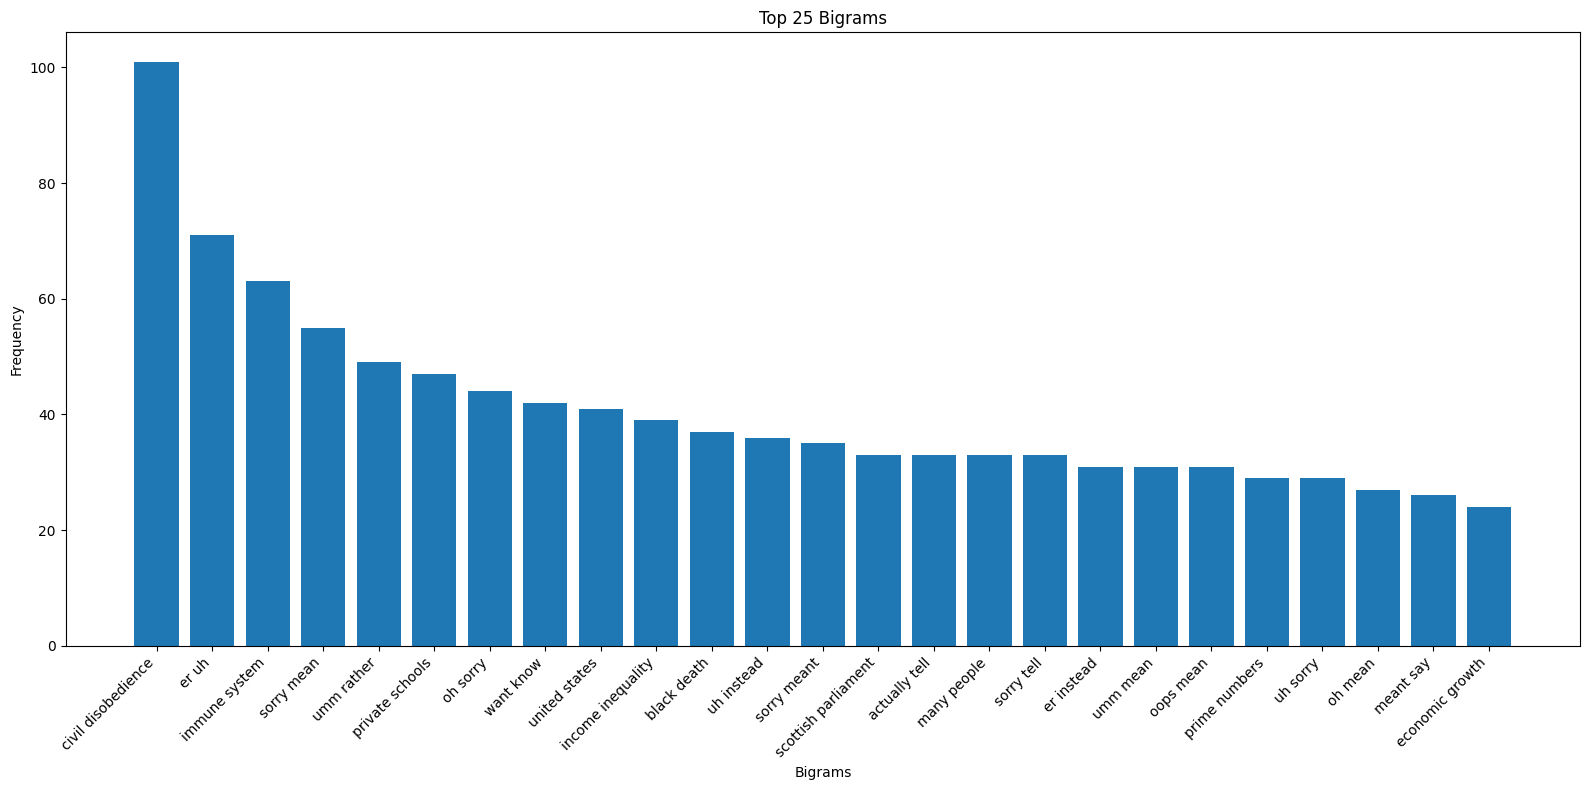

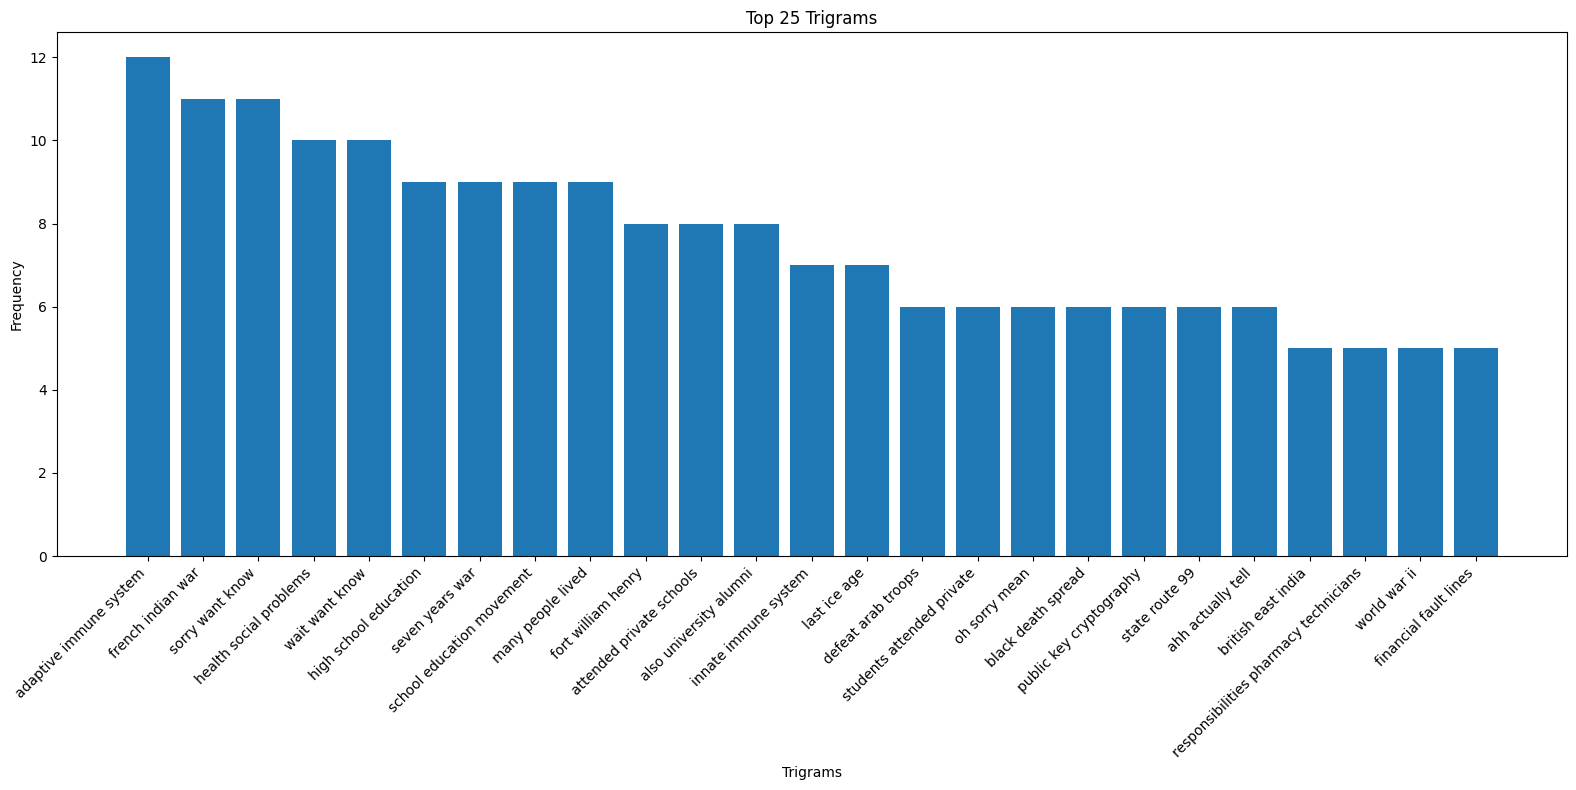


Average Levenshtein Distance: 26.585222502099075


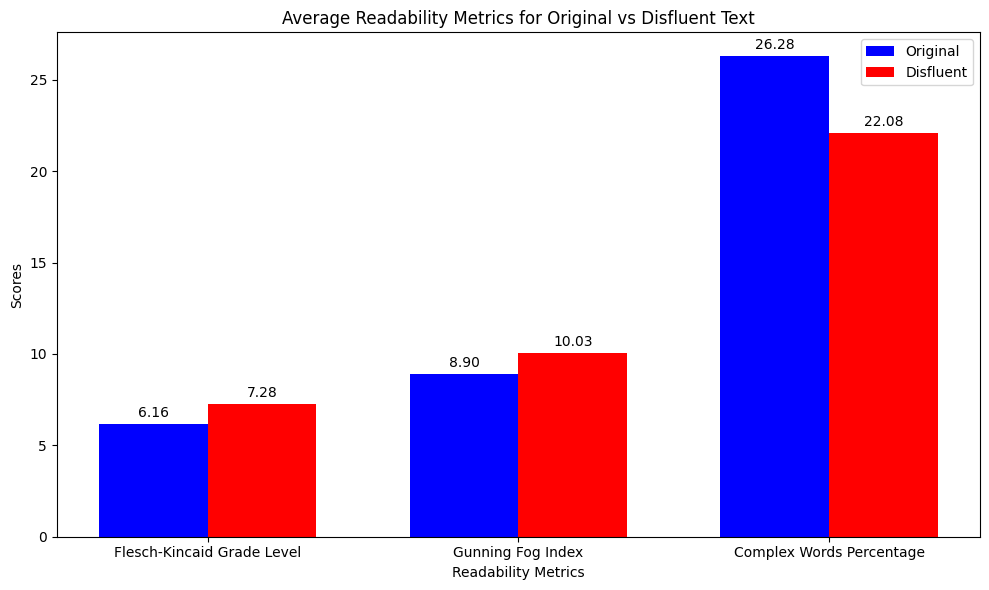

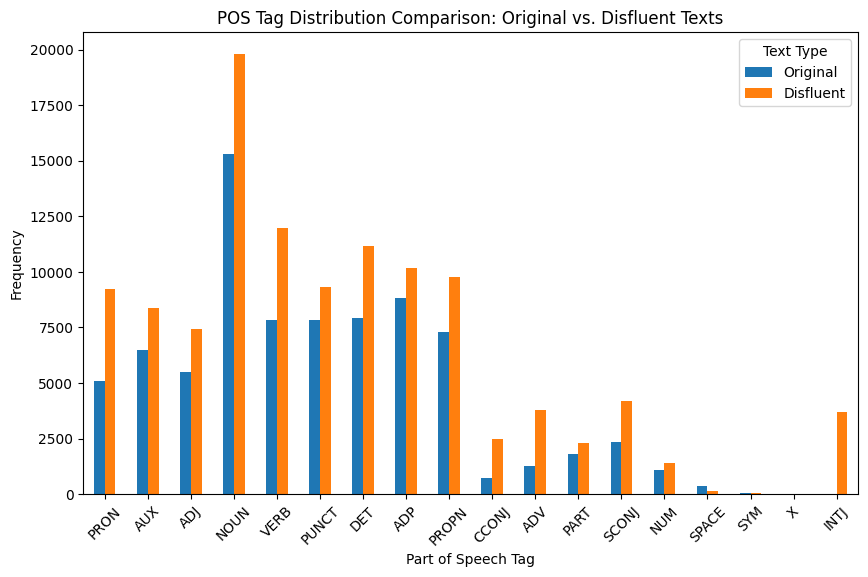

In [ ]:
analyze_disfluency(train_data)

### Insights
Disfluencies often involve repetitions and filler words: The higher  
frequency of pronouns, proper nouns, and verbs suggests that disfluent texts contain more repetitions and restarts, especially in noun phrases and verb phrases.

Interjections are a clear marker of disfluency: The sharp rise in interjections (INTJ) confirms that speakers often use filler words when they hesitate or need more time to think.

Higher use of punctuation in disfluent texts: This suggests that pauses and interruptions are more prevalent in disfluent speech, leading to more punctuation marks.

Adverbs and conjunctions may reflect uncertainty: The increased use of adverbs and coordinating conjunctions in disfluent texts suggests that speakers may add unnecessary words when they are uncertain or correcting themselves.

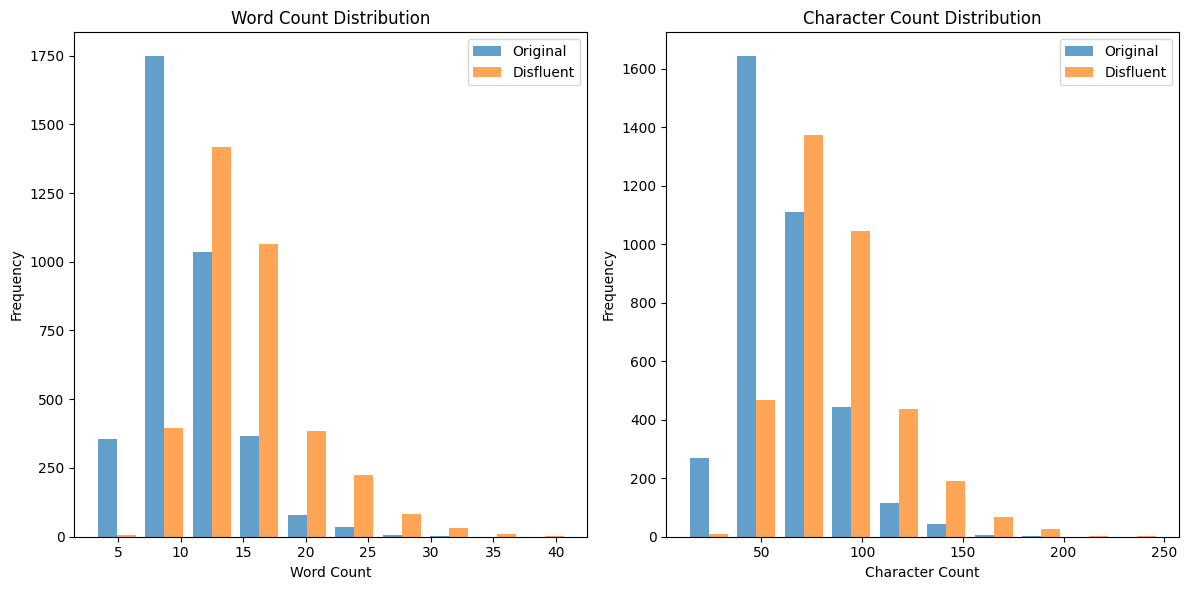

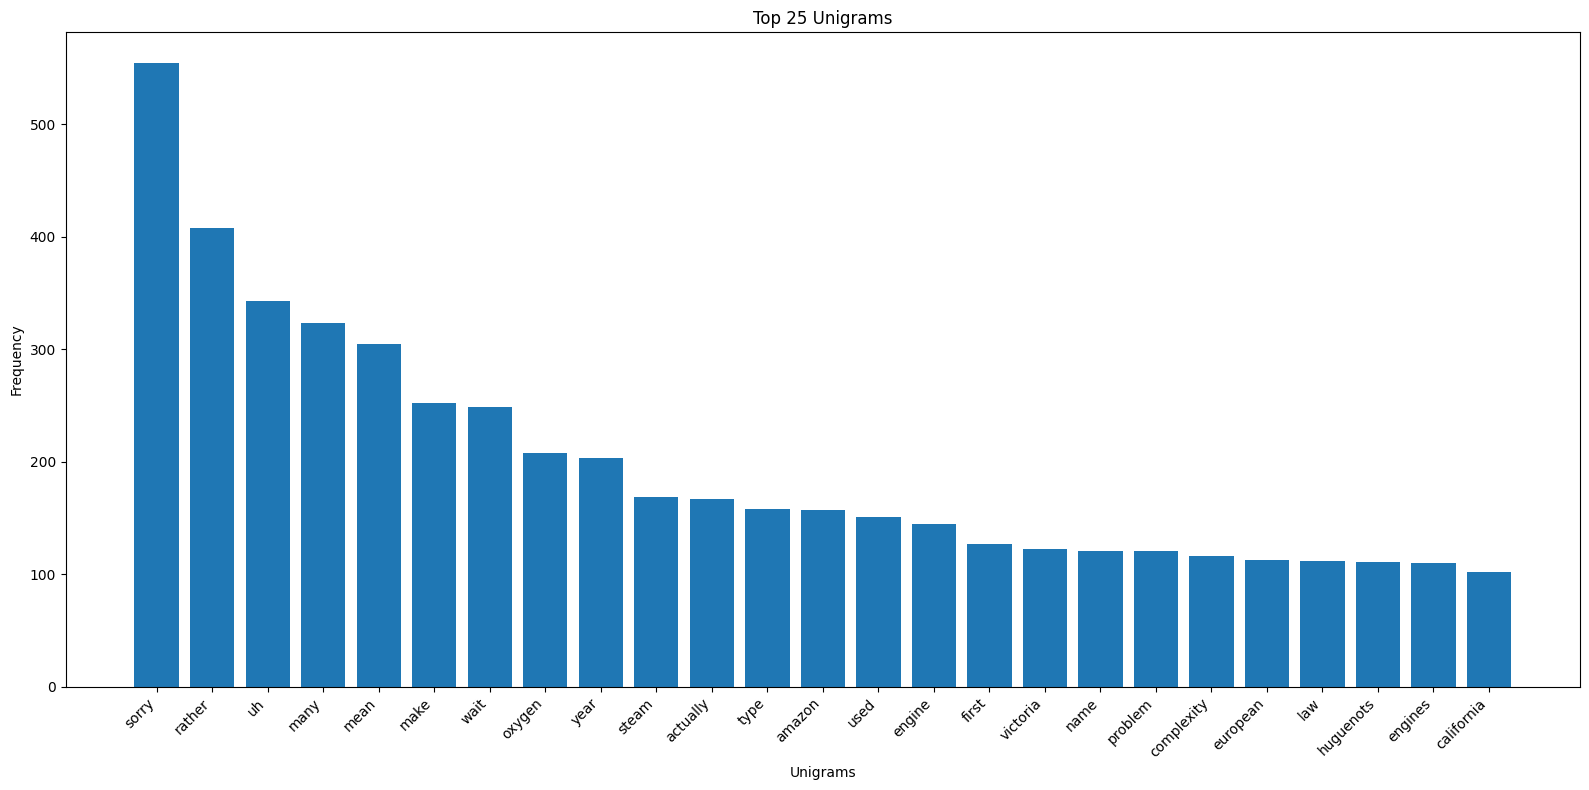

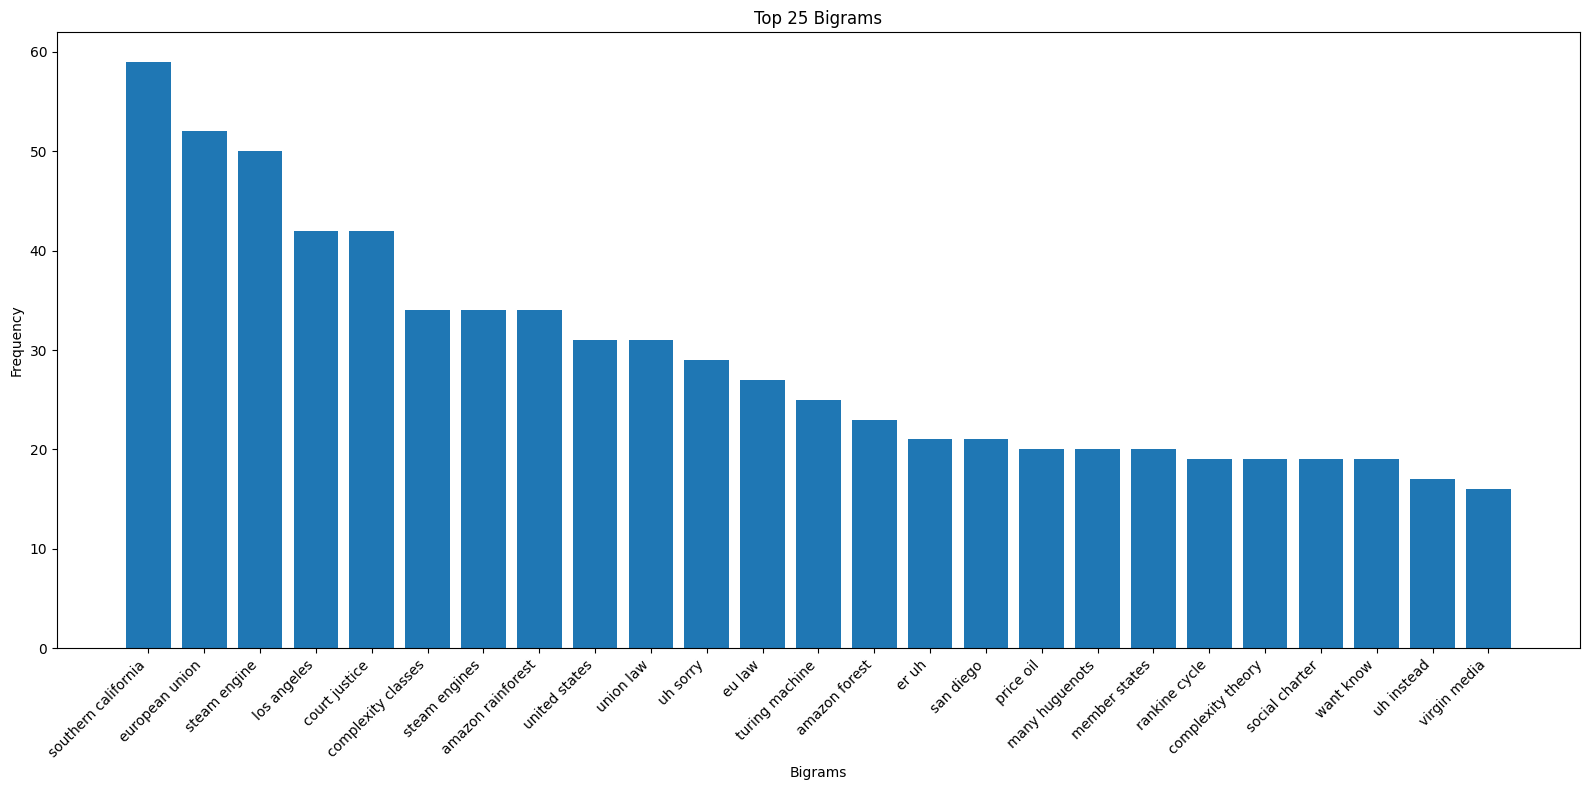

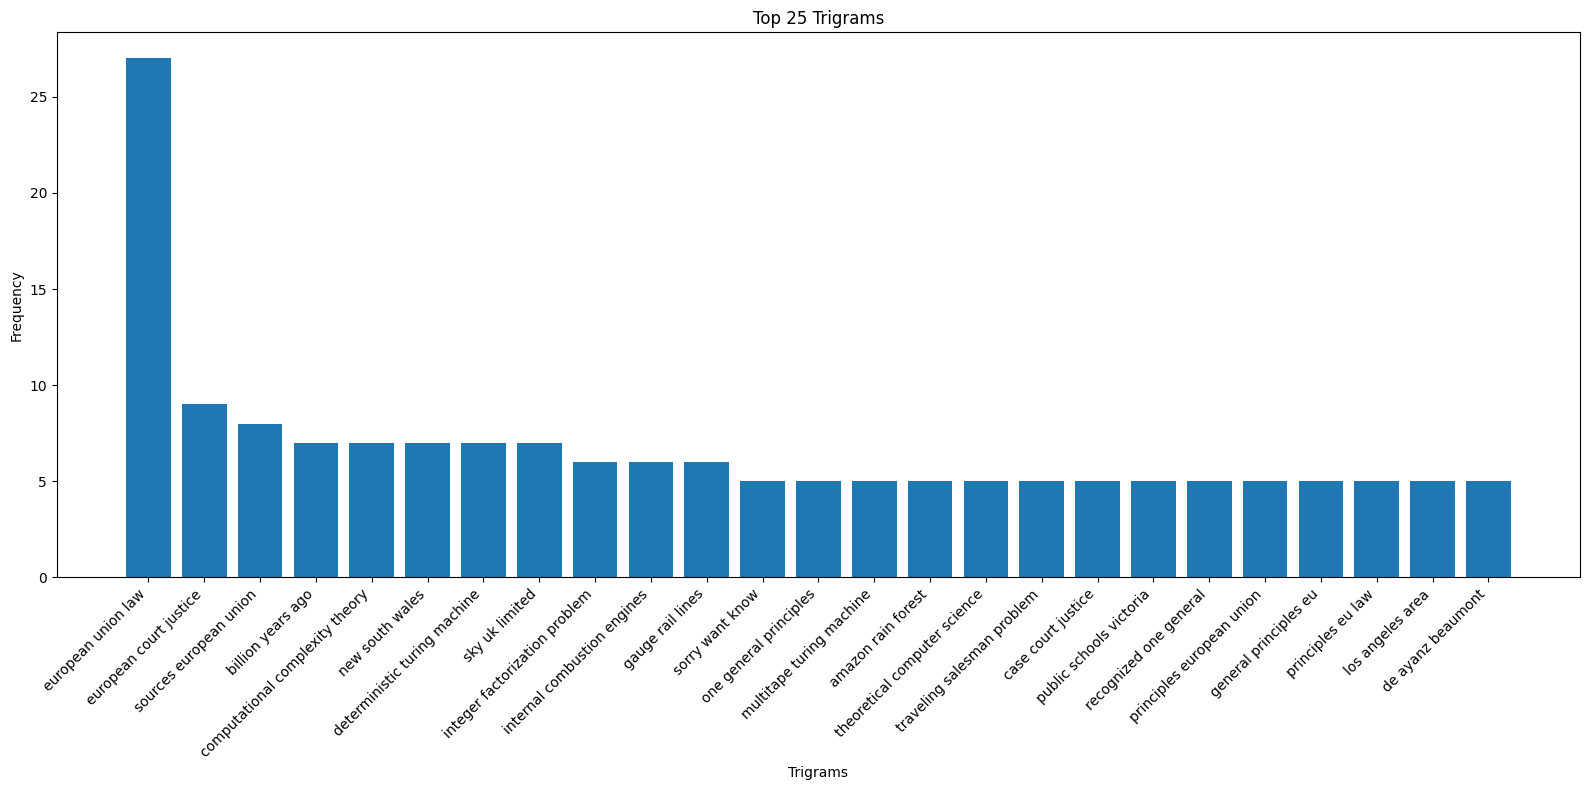


Average Levenshtein Distance: 27.229264260126758


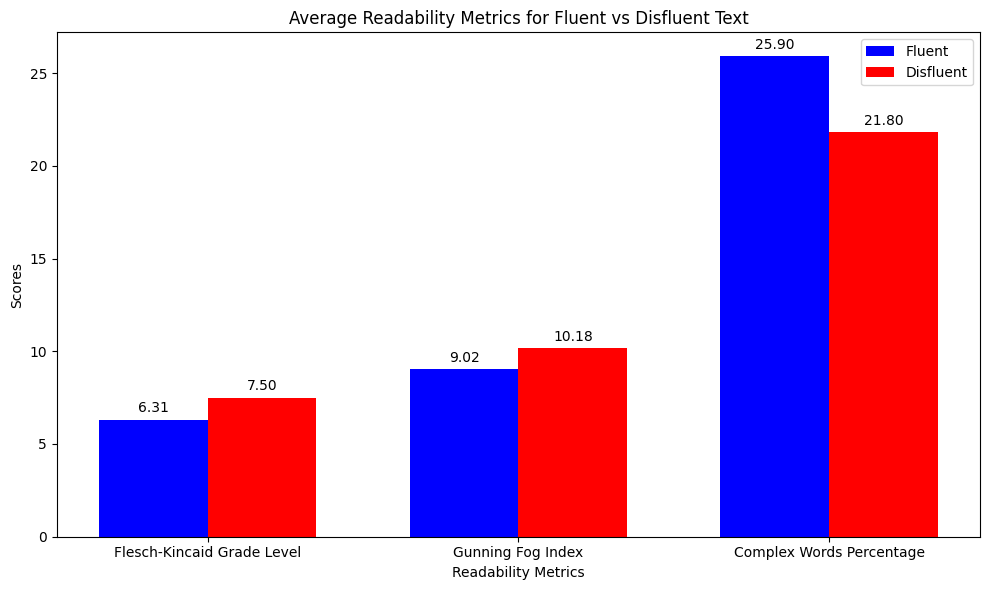

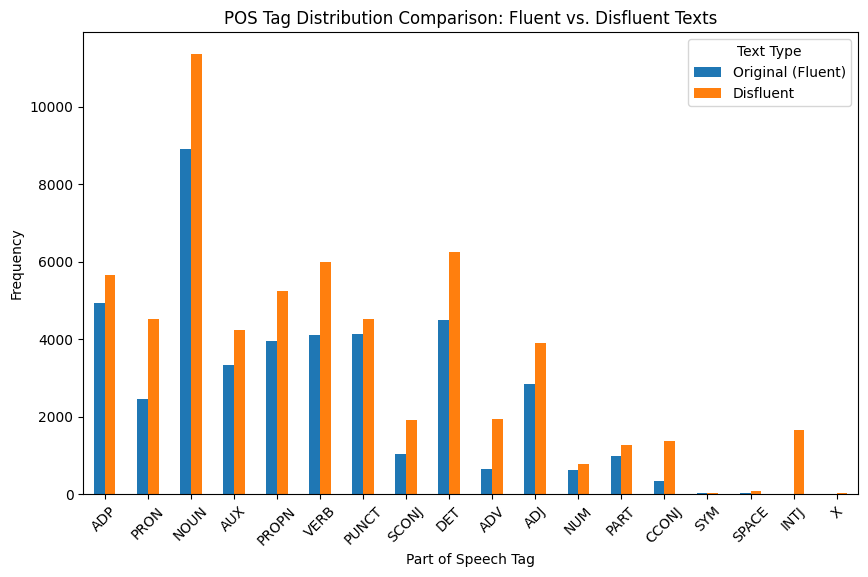

In [ ]:
analyze_disfluency(test_data)

## Analyzing Augmented Train Data
Data Distribution is similar to the originla training set

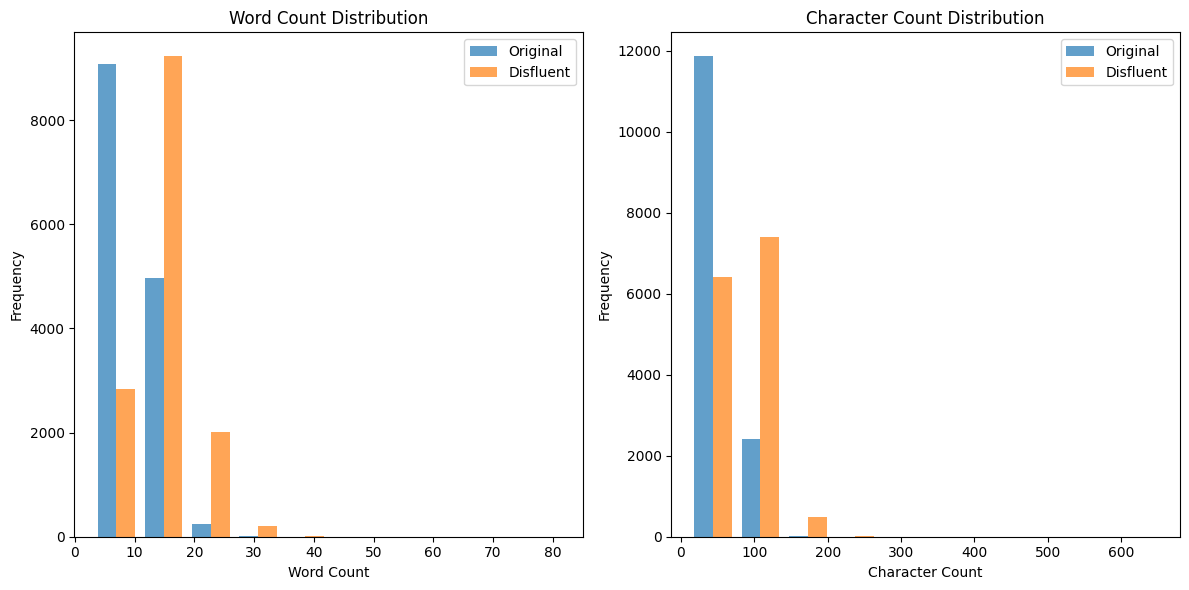

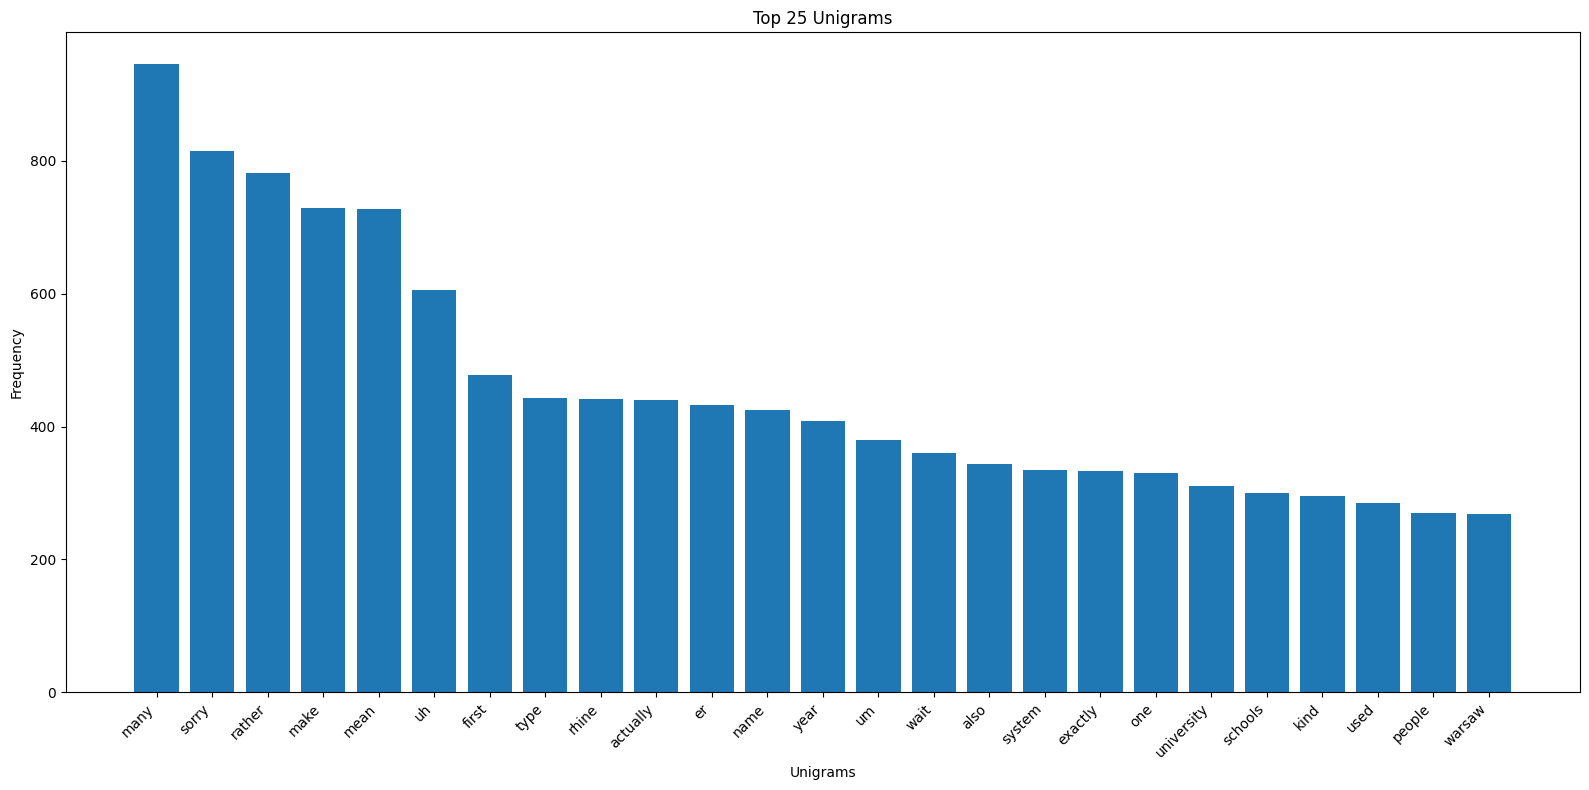

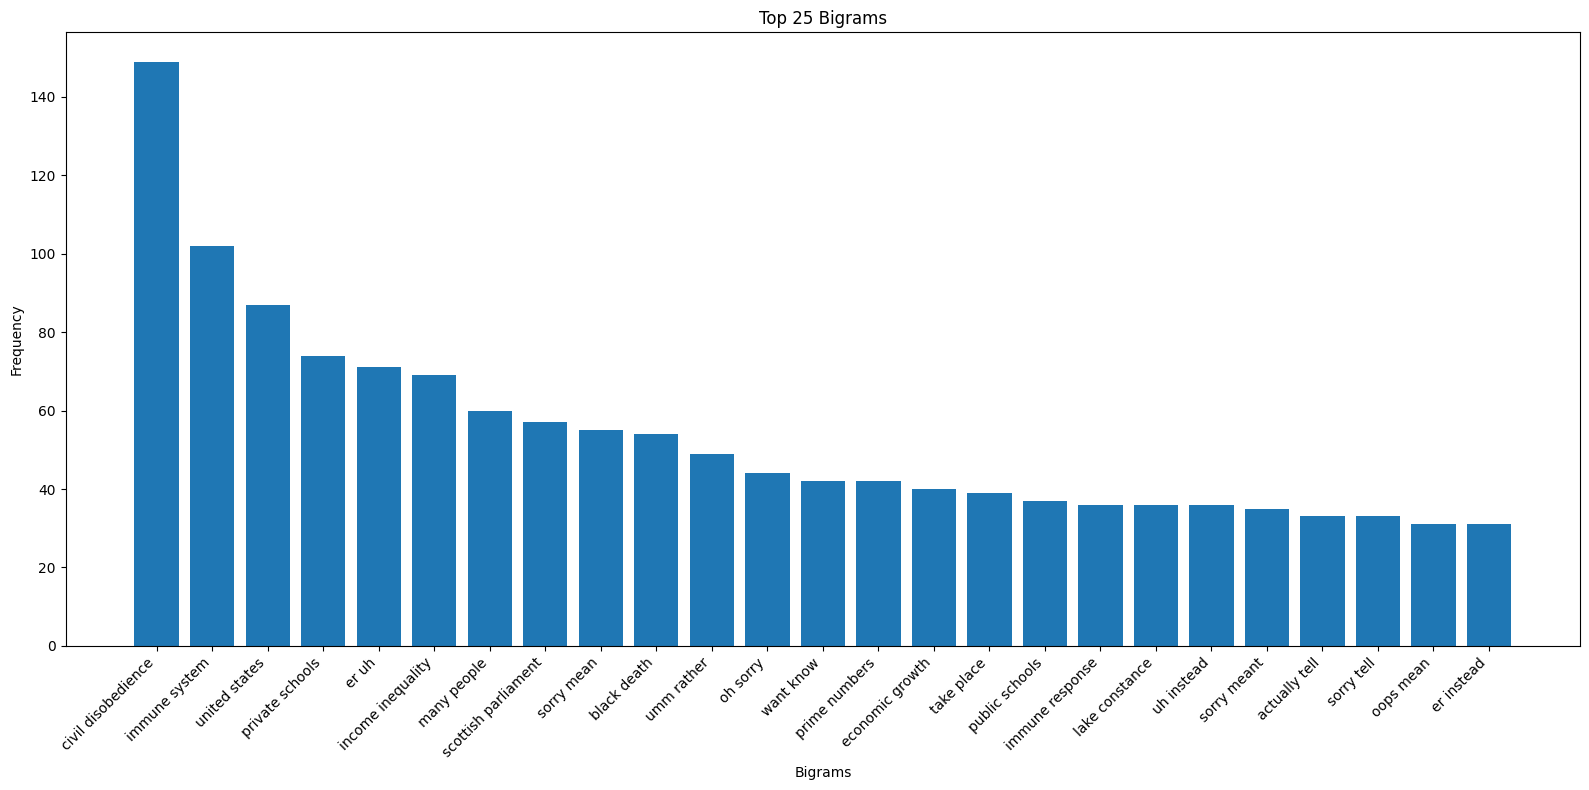

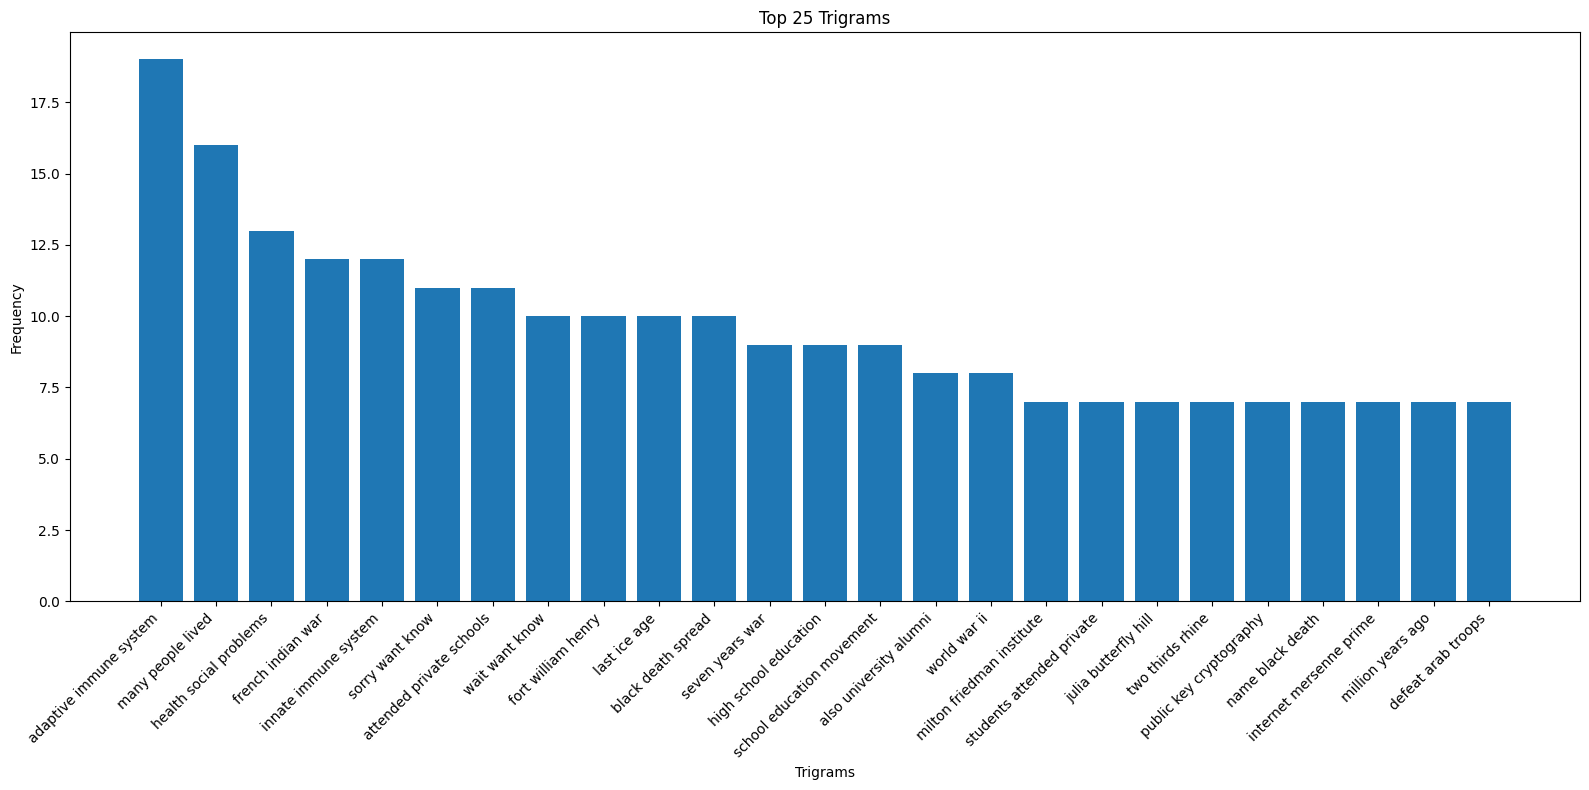

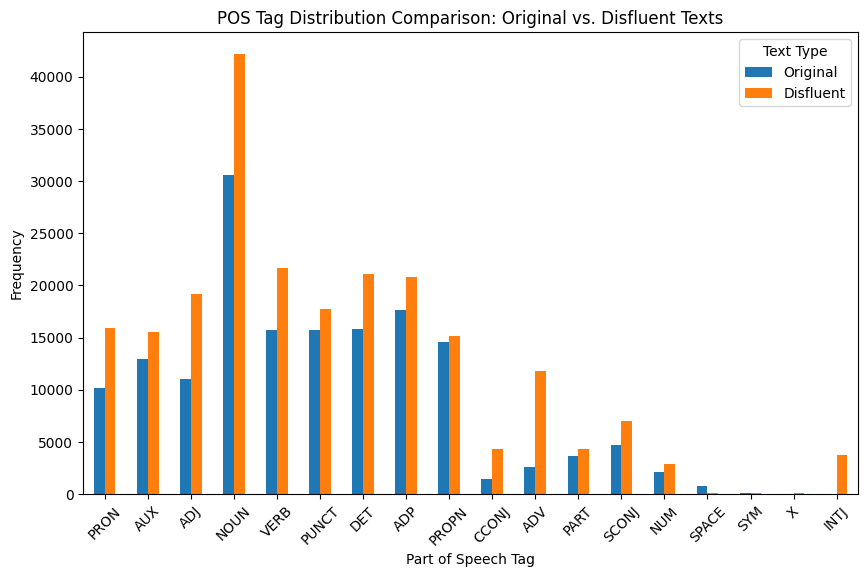


Average Levenshtein Distance: 32.09326896165687


In [7]:
train_aug = pd.read_csv('/content/train_augmeneted.csv')
analyze_disfluency(train_aug)

## Prediction Analysis
 BART Fine-tuned - Original Dataset)

In [12]:
## Fine tuned model
bart1 = pd.read_csv('BART_RUN_1.csv')
bart1.dropna(inplace=True)
bart1.drop(columns=['Unnamed: 0'], inplace=True)
bart1.head()

,Disfluent,Original (Fluent),Predictions (Fluent)
0,In what country is Norse found no wait Normandy not Norse?,In what country is Normandy located?,In what country is Normandy not Norse?
1,From which countries no tell me when were the Normans in Normandy?,When were the Normans in Normandy?,When were the Normans in Normandy?
2,From which Norse leader I mean countries did the Norse originate?,From which countries did the Norse originate?,From which countries did the Norse originate?
3,When I mean Who was the Norse leader?,Who was the Norse leader?,Who was the Norse leader?
4,When no what century did the Normans first gain their separate identity?,What century did the Normans first gain their separate identity?,What century did the Normans first gain their separate identity?


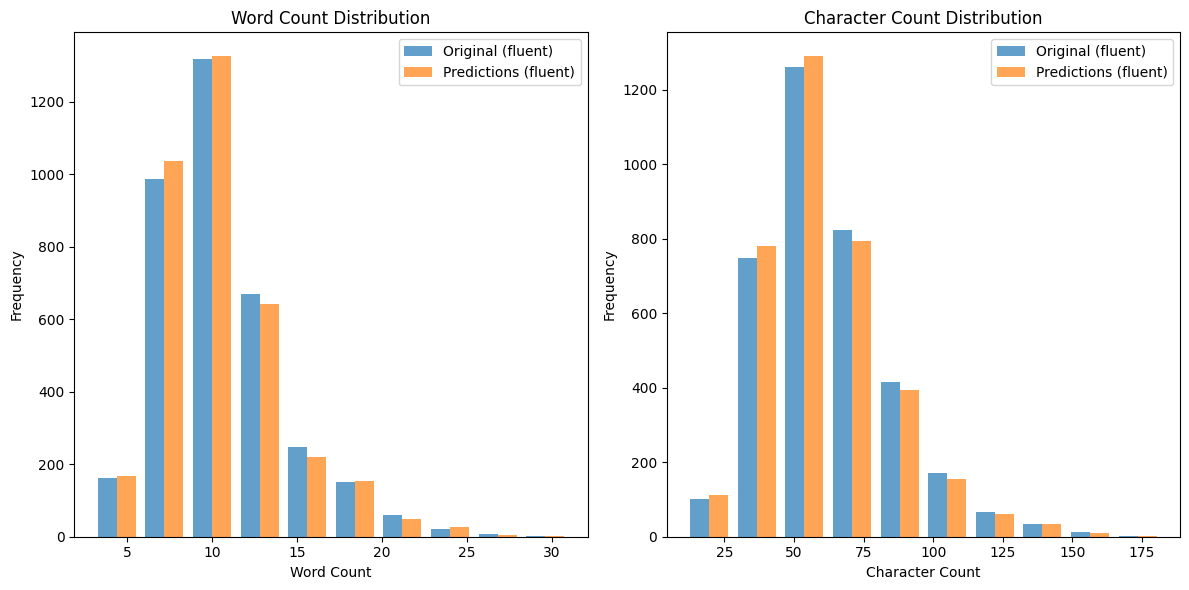

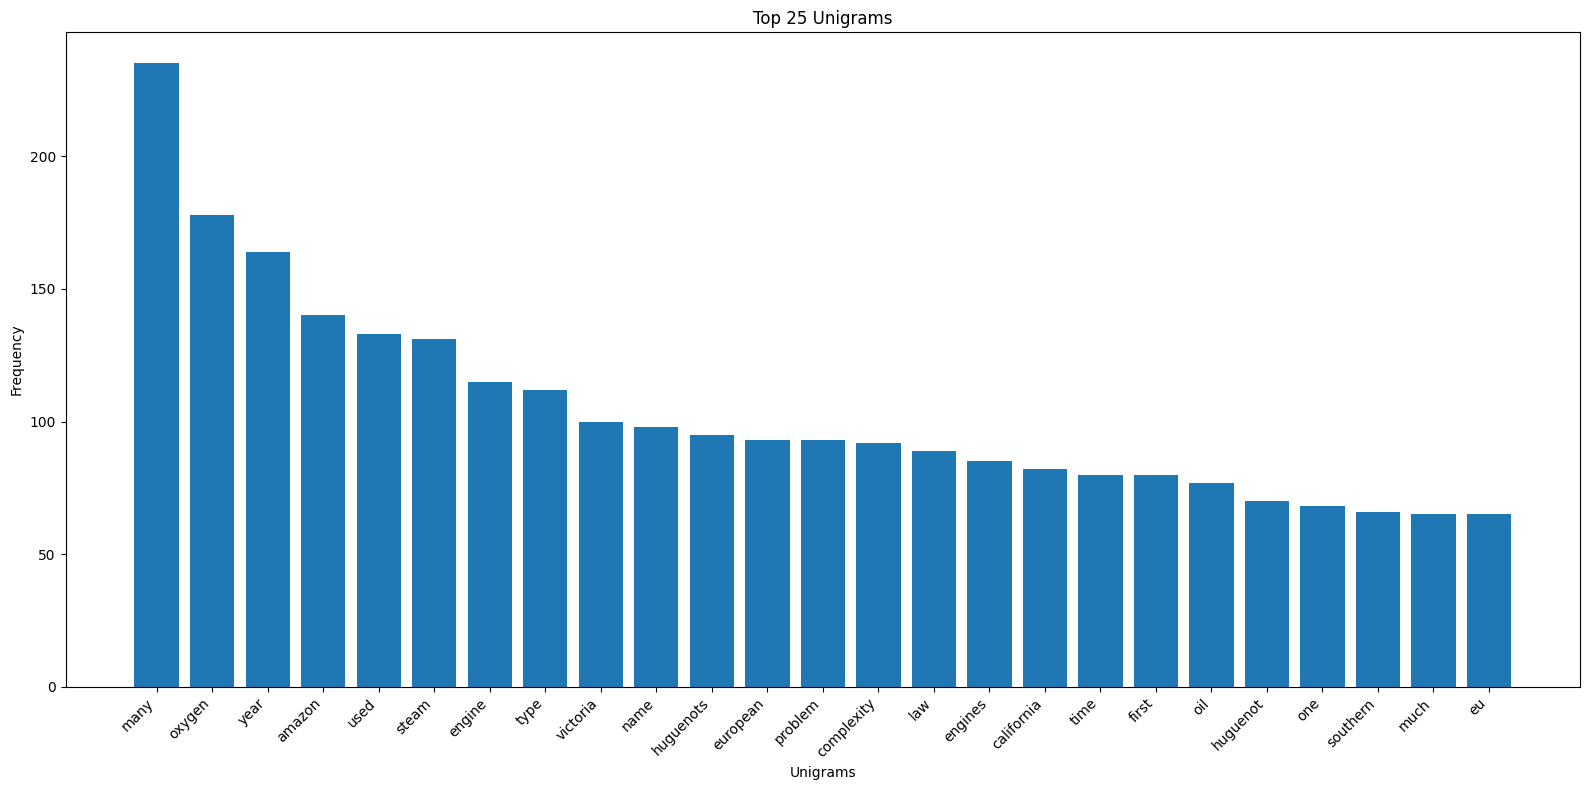

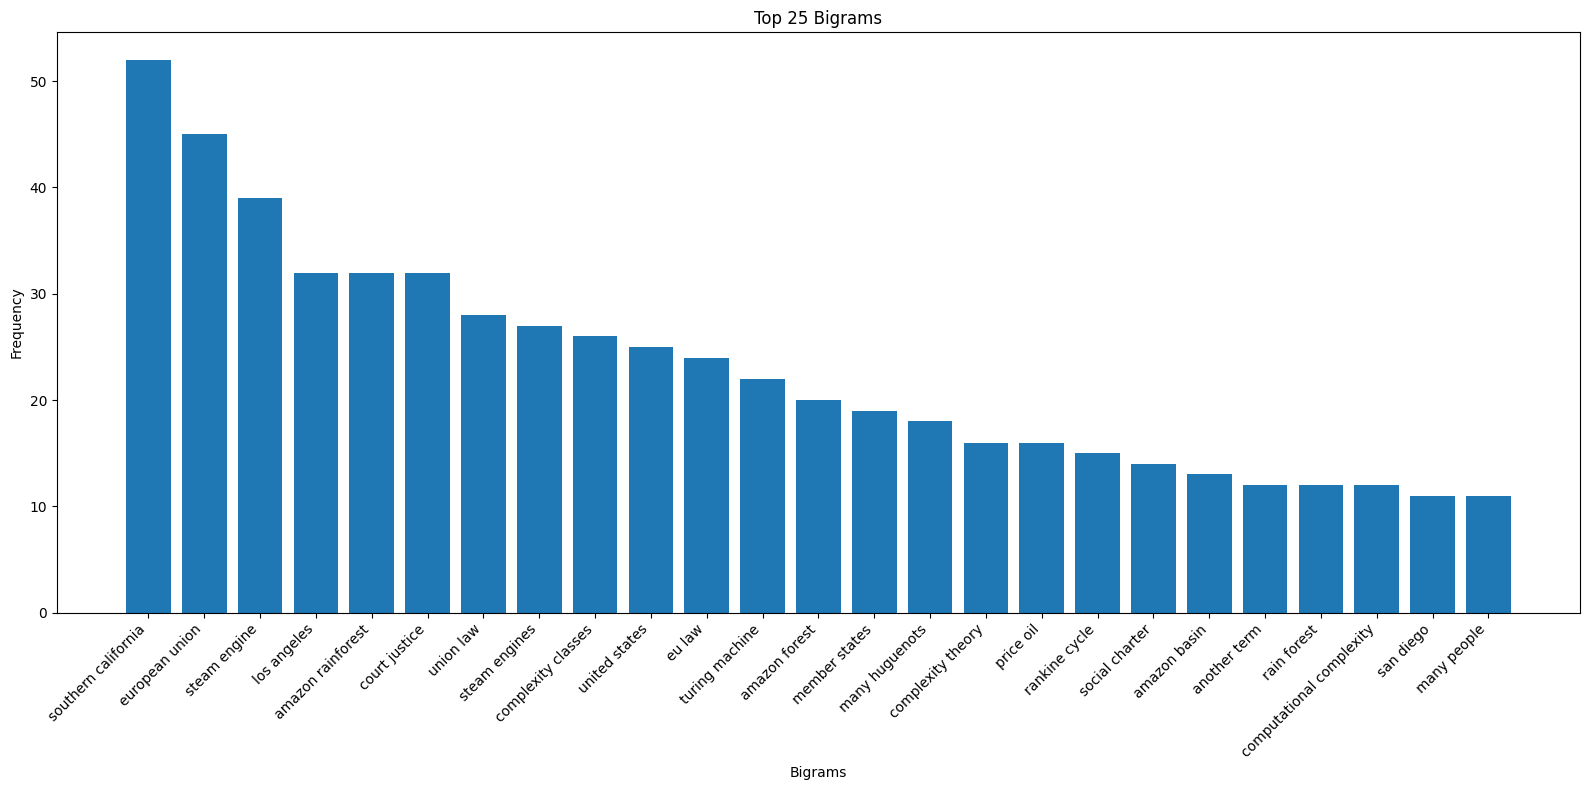

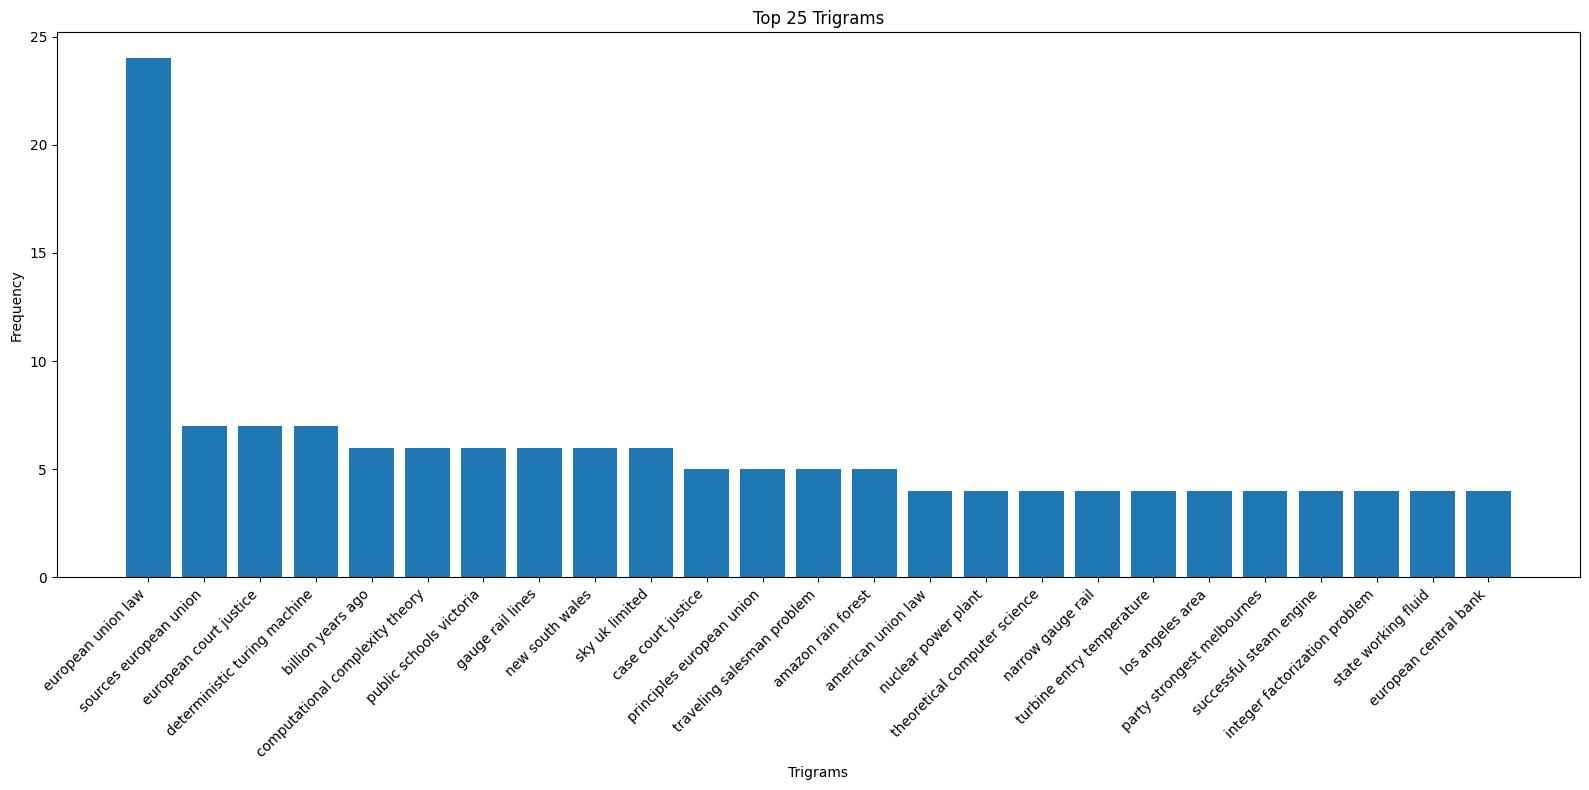


Average Levenshtein Distance: 4.726095343069717


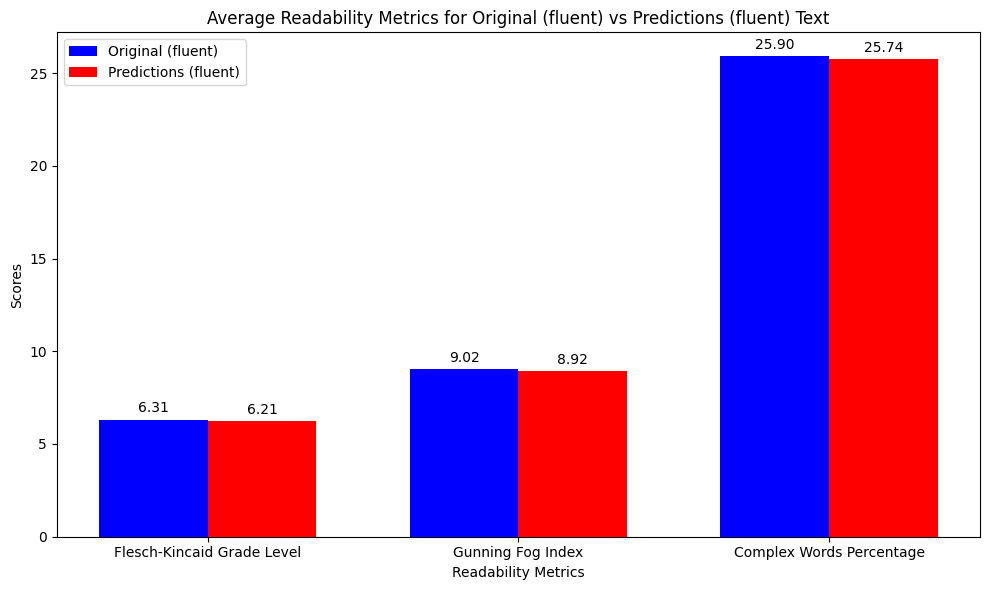

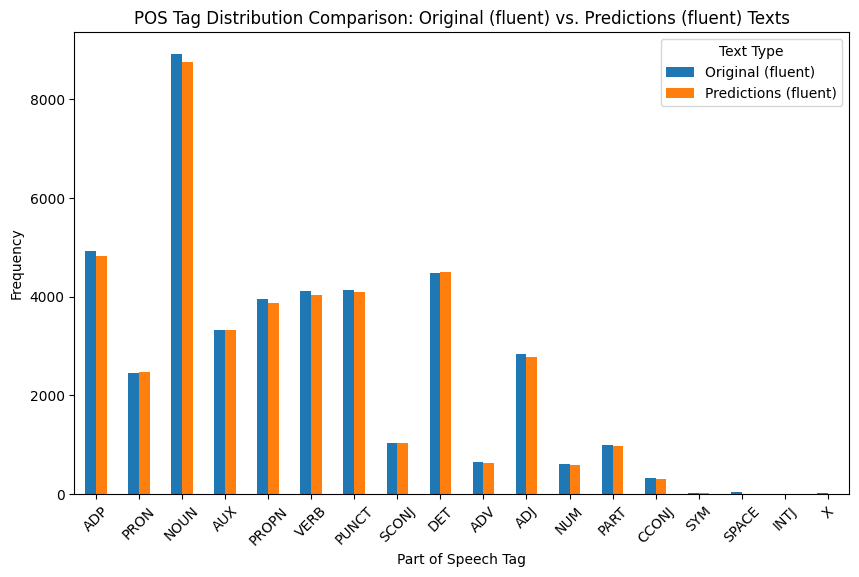

In [13]:
analyze_disfluency(bart1, col1='Original (Fluent)', col2='Predictions (Fluent)')

In [16]:
import logging
import transformers

# Suppress the specific warning from transformers
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)


results_df = evaluate_predictions(bart1)
print(results_df)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

    ROUGE-1   ROUGE-2   ROUGE-L      BLEU    METEOR  BERTScore Precision  \
0  0.953951  0.911474  0.943273  0.853771  0.932146              0.98963   

   BERTScore Recall  BERTScore F1  
0          0.987921      0.988741  
